# Transfer Learning and Fine-tuning with Keras Hub
This notebook demonstrates how to use **transfer learning** and **fine-tuning** with pre-trained models from [Keras Hub](https://keras.io/keras_hub/) to achieve better image classification accuracy than training a model from scratch. This is a common and effective strategy when you have a small dataset, limited computational resources, or insufficient time to train a large model from the beginning.

**Learning Objectives**
- **Transfer Learning**: Learn how to leverage a pre-trained model as a feature extractor.
- **Fine-tuning**: Understand how to fine-tune a pre-trained model's weights for a specific task.
- **Learning Rate Scheduling**: Discover how a learning rate schedule can be used to achieve stable and effective fine-tuning.

## Setup

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import pathlib

import IPython.display as display
import keras
import keras_hub
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Softmax,
)
from PIL import Image

2025-08-18 20:54:34.049264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755550474.071530   72994 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755550474.078187   72994 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploring the data

As usual, let's take a look at the data before we start building our model. We'll be using a creative-commons licensed flower photo dataset of 3670 images falling into 5 categories: 'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'.

The below [keras.utils.get_file](https://keras.io/api/utils/python_utils/#getfile-function) command downloads a dataset to the local Keras cache. To see the files through a terminal, copy the output of the cell below.

In [3]:
data_dir = keras.utils.get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)

# Print data path
print("cd", data_dir)

cd /home/jupyter/.keras/datasets/flower_photos


We can use python's built in [pathlib](https://docs.python.org/3/library/pathlib.html) tool to get a sense of this unstructured data.

In [4]:
data_dir_path = pathlib.Path(data_dir)

image_count = len(list(data_dir_path.glob("*/*/*.jpg")))
print("There are", image_count, "images.")

CLASS_NAMES = np.array(
    [
        item.name
        for item in data_dir_path.glob("*/*")
        if item.name != "LICENSE.txt"
    ]
)
print("These are the available classes:", CLASS_NAMES)

There are 3670 images.
These are the available classes: ['tulips' 'sunflowers' 'daisy' 'roses' 'dandelion']


Let's display some images so we can see what our model will be trying to learn.

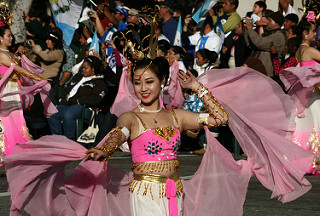

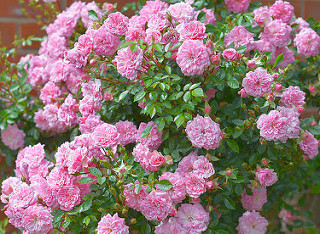

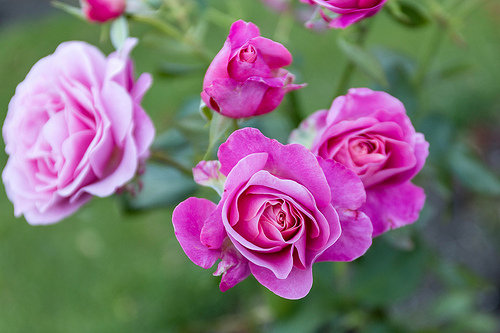

In [5]:
roses = list(data_dir_path.glob("*/roses/*"))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Building the Dataset
For training a machine learning model, the data must be organized and loaded efficiently. Here we use [keras.utils.image_dataset_from_directory](https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function) to create a tf.data.Dataset object. 

Ths method assumes the data is stored in this directory structure:



```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

The utility automatically handles:
- File Discovery: It scans the directory structure to find all image files.
- Labeling: It infers the class labels from the subdirectory names (e.g., roses, tulips).
- Splitting: It divides the data into training (80%) and validation (20%) subsets as specified by `validation_split` and return both subsets (`subset="both"`).
- Resizing: It resizes all images to a consistent size (224x224 pixels) to be compatible with the model architecture we'll use later.
- Batching: It groups the images into batches for efficient training, with a batch size of 32.

This process ensures the data is ready for model consumption without the need for manual loops or complex file handling.

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
# 10 is a magic number tuned for local training of this dataset.
VALIDATION_SPLIT = 0.2

SEED = 999

In [7]:
train_ds, eval_ds = keras.utils.image_dataset_from_directory(
    f"{data_dir}/flower_photos",
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="both",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode="categorical",
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


I0000 00:00:1755550480.256666   72994 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


## Simple CNN Model

These flower photos are much larger than handwritting recognition images in MNIST. They are about 10 times as many pixels per axis **and** there are three color channels, making the information here over 200 times larger!

How do our current techniques stand up? Copy your best model architecture over from the <a href="2_mnist_cnn.ipynb">MNIST models lab</a> and see how well it does after training for 10 epochs.

In [8]:
nclasses = len(CLASS_NAMES)
hidden_layer_1_neurons = 400
hidden_layer_2_neurons = 100
dropout_rate = 0.25
num_filters_1 = 64
kernel_size_1 = 3
pooling_size_1 = 2
num_filters_2 = 32
kernel_size_2 = 3
pooling_size_2 = 2

layers = [
    keras.layers.Rescaling(scale=1.0 / 255),
    Conv2D(
        num_filters_1,
        kernel_size=kernel_size_1,
        activation="relu",
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    ),
    MaxPooling2D(pooling_size_1),
    Conv2D(num_filters_2, kernel_size=kernel_size_2, activation="relu"),
    MaxPooling2D(pooling_size_2),
    Flatten(),
    Dense(hidden_layer_1_neurons, activation="relu"),
    Dense(hidden_layer_2_neurons, activation="relu"),
    Dropout(dropout_rate),
    Dense(nclasses),
    Softmax(),
]

old_model = Sequential(layers)
old_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [9]:
history = old_model.fit(
    train_ds,
    epochs=10,
    validation_data=eval_ds,
)

Epoch 1/10


I0000 00:00:1755550484.828621   73043 service.cc:148] XLA service 0x7fb544003cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755550484.828666   73043 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755550485.090491   73043 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/92 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.1580 - loss: 2.7367

I0000 00:00:1755550489.784818   73043 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.3239 - loss: 1.7063 - val_accuracy: 0.4823 - val_loss: 1.2513
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5104 - loss: 1.2225 - val_accuracy: 0.5436 - val_loss: 1.1081
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6193 - loss: 0.9651 - val_accuracy: 0.5668 - val_loss: 1.2150
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7038 - loss: 0.7882 - val_accuracy: 0.6226 - val_loss: 1.0990
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8347 - loss: 0.4814 - val_accuracy: 0.5613 - val_loss: 1.5751
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9004 - loss: 0.2966 - val_accuracy: 0.5872 - val_loss: 1.7516
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9466 - loss: 0.1806 - val_accuracy: 0.5954 - val_loss: 1.8983
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9601 - loss: 0.1166 - val_accuracy: 0.5599 - val_loss: 

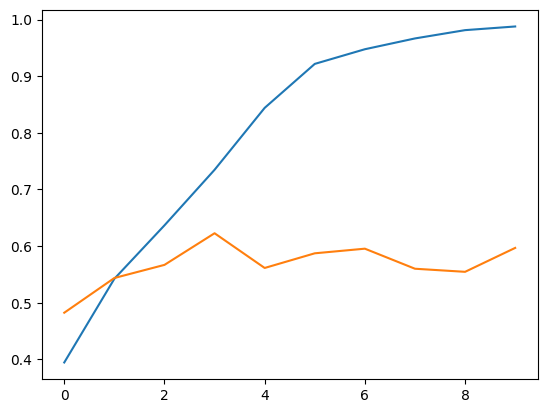

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

## Transfer Learning with Keras Hub

If your model is like mine, it learns a little bit, slightly better then random, but *ugh*, it's overfitting! Since our model is too shallow for this dataset, it may be using very low-level features (like colors) and failing to capture the overall semantics.

To overcome the limitations of the simple CNN, we introduce transfer learning. 

We're leveraging a pre-trained image model—MobileNetV3 from Keras Hub—and repurposing it for our task. This model is ideal because it's lightweight and built for mobile inference.

We can retrieve a pre-trained feature extractor object by specifying a model identifier in the `keras_hub.models.Backbone.from_preset()` function. Please refer to [the document](https://keras.io/keras_hub/presets/) for available models.

Here we set `backbone.trainable` to `False` for transfer learning, so the millions of weights in the pre-trained model are not updated during training. 

In [11]:
backbone = keras_hub.models.Backbone.from_preset(
    "mobilenet_v3_large_100_imagenet_21k",
)
backbone.trainable = False

backbone.summary()

Model: "mobile_net_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_pad (ZeroPadding2D)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_conv (Conv2D)             │ (None, None, None, 16) │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_batch_norm                │ (None, None, None, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, None, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_0 (DepthwiseConvBlock)  │ (None, None, None, 16) │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_0                       │ (None, None, None, 24) │         3,744 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_1                       │ (None, None, None, 24) │         4,776 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_0                       │ (None, None, None, 40) │        10,696 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_1                       │ (None, None, None, 40) │        21,552 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_2                       │ (None, None, None, 40) │        21,552 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_0                       │ (None, None, None, 80) │        33,200 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_1                       │ (None, None, None, 80) │        35,720 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_2                       │ (None, None, None, 80) │        32,888 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_3                       │ (None, None, None, 80) │        32,888 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_0                       │ (None, None, None,     │       216,568 │
│ (InvertedResidualBlock)         │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_1                       │ (None, None, None,     │       389,032 │
│ (InvertedResidualBlock)         │ 112)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_0                       │ (None, None, None,     │       432,232 │
│ (InvertedResidualBlock)         │ 160)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

Note that the "Trainable params" is 0 in the backbone.

Instead, a new classification head (a simple Dense layer) is added on top, and only this new head is trained to classify the flower images. 

This approach leverages the powerful, pre-learned features of the backbone to achieve a strong performance baseline quickly, without the risk of overfitting the small dataset. 

In [12]:
transfer_model = keras.Sequential(
    [
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        keras.layers.Rescaling(scale=1.0 / 255),
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(
            nclasses,
            activation="softmax",
            kernel_regularizer=keras.regularizers.l2(0.0001),
        ),
    ]
)
# transfer_model.build((None,) + (IMG_HEIGHT, IMG_WIDTH, 3))
transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobile_net_backbone             │ (None, 7, 7, 960)      │     2,996,352 │
│ (MobileNetBackbone)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 960)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [13]:
transfer_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [14]:
history = transfer_model.fit(
    train_ds,
    epochs=10,
    validation_data=eval_ds,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.4261 - loss: 6.4247 - val_accuracy: 0.7575 - val_loss: 1.8231
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7327 - loss: 2.3186 - val_accuracy: 0.8174 - val_loss: 1.4062
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7863 - loss: 1.7458 - val_accuracy: 0.8243 - val_loss: 1.3645
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8189 - loss: 1.5337 - val_accuracy: 0.8420 - val_loss: 1.2334
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8432 - loss: 1.0400 - val_accuracy: 0.8447 - val_loss: 1.2078
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8537 - loss: 0.9252 - val_accuracy: 0.8447 - val_loss: 1.1655
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8541 - loss: 0.9566 - val_accuracy: 0.8610 - val_loss: 0.9552
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8789 - loss: 0.7780 - val_accuracy: 0.8420 -

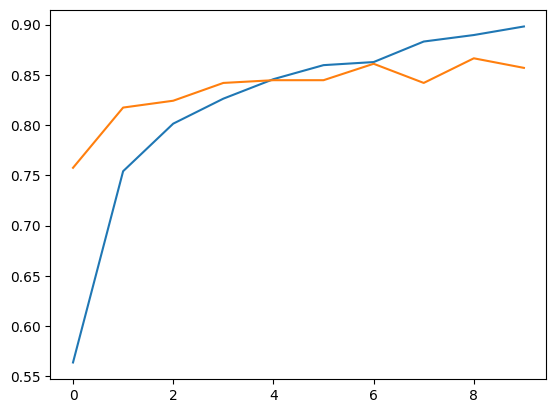

In [15]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

Alright, looking better! Still, there's room to improve.

## Finetuning MobileNet
Following the transfer learning step, let's see how fine-tuning works. Here we unfreeze the backbone and train with our classification head. 

Note that we **don't** set `backbone.trainable` to `False` to leave it trainable.

In [16]:
backbone = keras_hub.models.Backbone.from_preset(
    "mobilenet_v3_large_100_imagenet_21k",
)

# Leave trainable True for fine-tuning
# backbone.trainable = False

finetune_model = keras.Sequential(
    [
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        keras.layers.Rescaling(scale=1.0 / 255),
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(
            nclasses,
            activation="softmax",
            kernel_regularizer=keras.regularizers.l2(0.0001),
        ),
    ]
)
finetune_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobile_net_backbone             │ (None, 7, 7, 960)      │     2,996,352 │
│ (MobileNetBackbone)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 960)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 2,976,757 (11.36 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [17]:
finetune_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

history = finetune_model.fit(
    train_ds,
    epochs=10,
    validation_data=eval_ds,
)

Epoch 1/10


E0000 00:00:1755550645.329274   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550645.468819   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550645.898410   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550646.036350   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6144 - loss: 3.3691

E0000 00:00:1755550677.654225   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550677.790891   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550678.201411   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755550678.339148   73043 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 432ms/step - accuracy: 0.6169 - loss: 3.3277 - val_accuracy: 0.8447 - val_loss: 0.5208
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8780 - loss: 0.3628 - val_accuracy: 0.8896 - val_loss: 0.2908
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9316 - loss: 0.2173 - val_accuracy: 0.8992 - val_loss: 0.3563
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9359 - loss: 0.1912 - val_accuracy: 0.8896 - val_loss: 0.3462
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9559 - loss: 0.1222 - val_accuracy: 0.9128 - val_loss: 0.3018
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9749 - loss: 0.1138 - val_accuracy: 0.8951 - val_loss: 0.3109
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9563 - loss: 0.1223 - val_accuracy: 0.8992 - val_loss: 0.3652
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9539 - loss: 0.1515 - val_accuracy: 0.8869 - val_loss: 

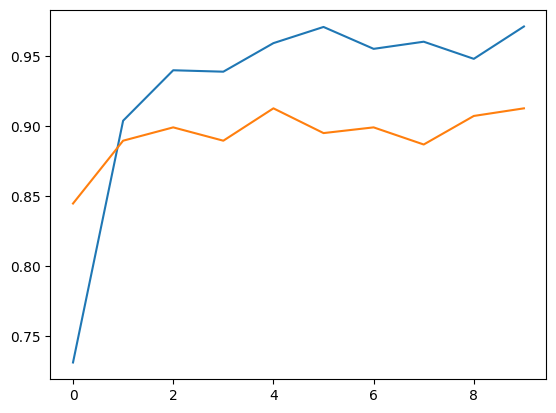

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

While the training accuracy looks better than the previous case, the validation accuracy remains the same.

Because now we are tuning a lot of parameters in Mobilenet, it easily overfits to this small dataset.

Furthermore, the default learning rate might have corrupted the knowledge MobileNet acquired during pre-training. A careful selection of the learning rate is crucial for effective fine-tuning.


## Learning Rate Schedule for Fine-tuning

Now, let's add an additional technique for fine-tuning.
Since fine-tuning is very sensitive to the learning rate, it is important to use a carefully designed **learning rate schedule**.


A typical learning rate schedule involves two phases: 
- **Warmup Phase**: The learning rate starts small and increases slowly to prevent breaking pre-trained model patterns and to ease into the new task
- **Decay Phase**: The learning rate is gradually reduced for finer tuning and improved convergence

Here we design this schedule using `keras.optimizers.schedules.CosineDecay`, where we can specify the warmup period flexibly.

In [19]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

warmup_tgt = 0.001
scheduler = keras.optimizers.schedules.CosineDecay(
    0.0,
    num_train_steps,
    warmup_target=warmup_tgt,
    warmup_steps=num_warmup_steps,
)

optimizer = keras.optimizers.Adam(learning_rate=scheduler)

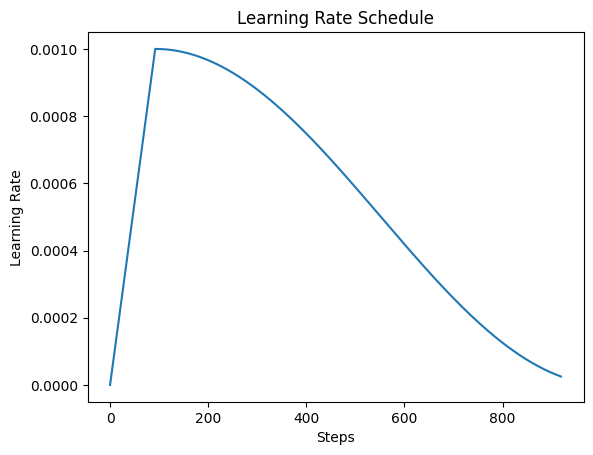

In [20]:
plt.plot([scheduler(lr) for lr in range(num_train_steps)])
plt.title("Learning Rate Schedule")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [21]:
backbone = keras_hub.models.Backbone.from_preset(
    "mobilenet_v3_large_100_imagenet_21k",
)

ft_lr_schedule_model = keras.Sequential(
    [
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        keras.layers.Rescaling(scale=1.0 / 255),
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(
            nclasses,
            activation="softmax",
            kernel_regularizer=keras.regularizers.l2(0.0001),
        ),
    ]
)

Let's train the same model using the new learning rate scheduler.

In [22]:
ft_lr_schedule_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

history = ft_lr_schedule_model.fit(
    train_ds,
    epochs=10,
    validation_data=eval_ds,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 391ms/step - accuracy: 0.4658 - loss: 6.2142 - val_accuracy: 0.8515 - val_loss: 0.6525
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8651 - loss: 0.4939 - val_accuracy: 0.8896 - val_loss: 0.3549
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9331 - loss: 0.2251 - val_accuracy: 0.9046 - val_loss: 0.3476
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9646 - loss: 0.1141 - val_accuracy: 0.9183 - val_loss: 0.3064
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9786 - loss: 0.0612 - val_accuracy: 0.9278 - val_loss: 0.2876
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9808 - loss: 0.0602 - val_accuracy: 0.9251 - val_loss: 0.2798
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9885 - loss: 0.0293 - val_accuracy: 0.9305 - val_loss: 0.3212
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9926 - loss: 0.0241 - val_accuracy: 0.9401 -

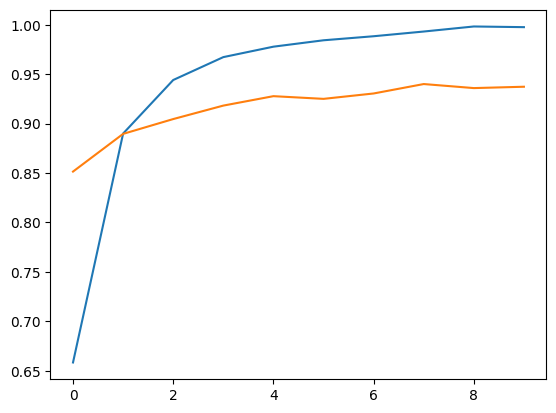

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

Thanks to the new learning rate schedule, we're now seeing better training and validation performance, as well as a more stable learning curve.

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.